# 1. Understanding Transfer Learning

### What is Transfer Learning?
Transfer learning involves taking a pre-trained model (trained on a large dataset like ImageNet) and adapting it to a new, related task (like classifying CIFAR-10 images). The main benefits are:

- **Reduced Training Time:** Leveraging learned features reduces the training time.
- **Improved Performance:** Pre-trained models often yield better performance, especially with limited data.
- **Less Data Required:** Helpful when you have a smaller dataset.

    
### Strategies for Transfer Learning

**1. Full Fine-Tuning:**
- Load a pre-trained model.
- Replace the final layer to match the number of classes in your dataset.
- Train the entire model (all layers are trainable).

**2. Partial Fine-Tuning:**
- Load a pre-trained model.
- Freeze early layers to retain learned features.
- Replace the final layer.
- Train only the un-frozen layers.

**3. Feature Extraction:**
- Load a pre-trained model.
- Freeze all layers except the final layer.
- Replace the final layer.
- Train only the final layer.

# 2. Preparing the CIFAR-10 Dataset

### About CIFAR-10

**- Description:** The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

**- Classes:** Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

### Data Preprocessing

**- Normalization:** Scale pixel values to be between 0 and 1 or standardize to zero mean and unit variance.

**- Resizing:** ResNet models expect images of size 224x224. We'll resize CIFAR-10 images accordingly.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images from 32x32 to 224x224 to match ResNet's expected input size.
    transforms.ToTensor(),  #  Converts images to PyTorch tensors.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Applies standard normalization used for ImageNet-trained models.
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Load the training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
# Define the CIFAR-10 class labels
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to unnormalize and display images
def unnormalize(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))  # Change the tensor shape to (H, W, C)
    img = (img * std) + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
    return img

# Display a few images from the training dataset
def show_images(dataset, num_images=8, title='Training Images'):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(title, fontsize=15)
    for idx in range(num_images):
        ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
        image, label = dataset[idx]
        image = unnormalize(image, mean, std)
        plt.imshow(image)
        ax.set_title(classes[label])

    plt.tight_layout()
    plt.show()

Displaying images from the training dataset...


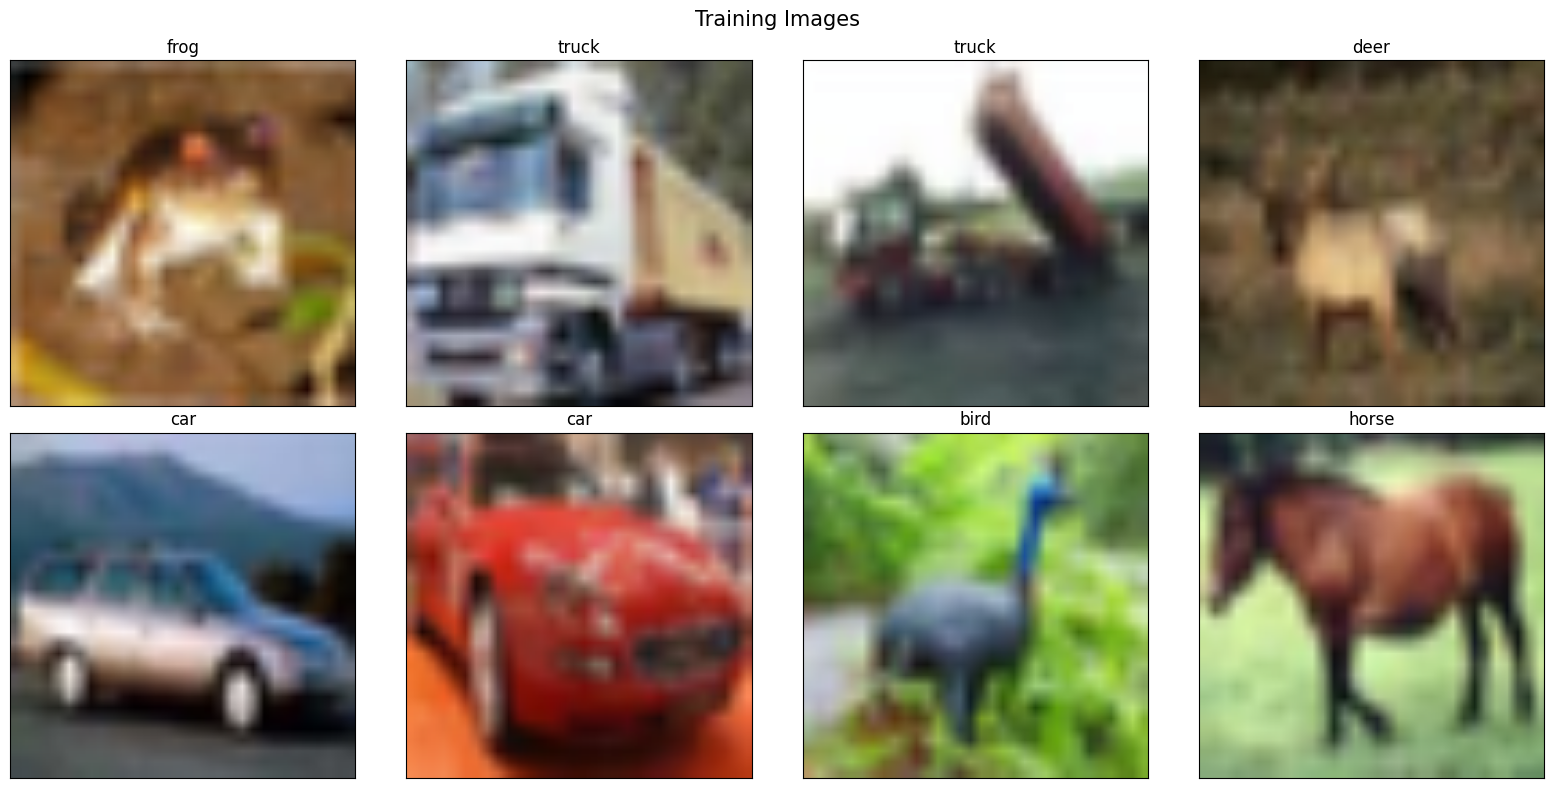

In [13]:
# Display images from the training dataset
print("Displaying images from the training dataset...")
show_images(train_dataset, num_images=8, title='Training Images')

Displaying images from the test dataset...


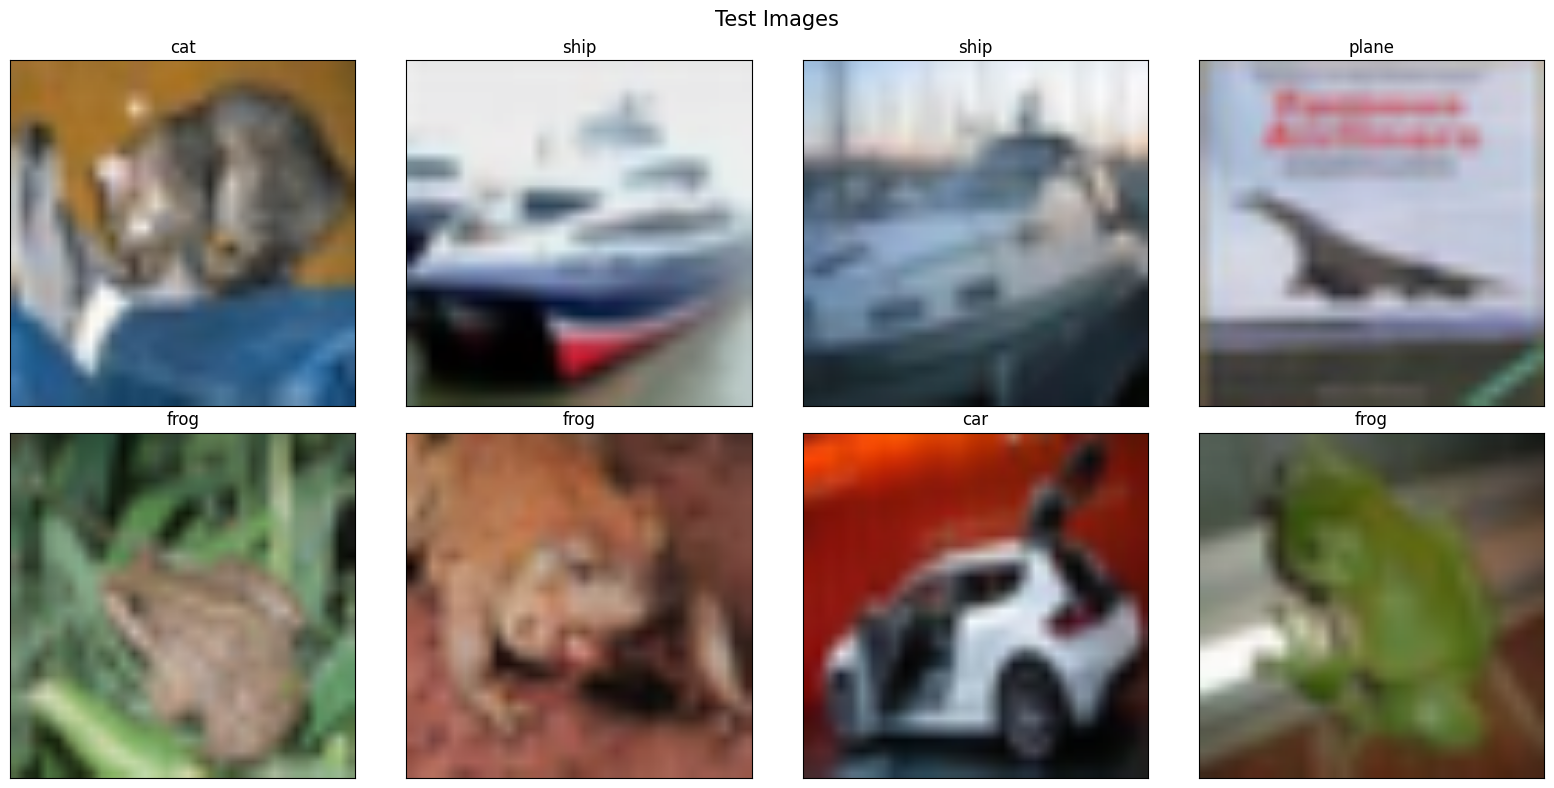

In [14]:
# Display images from the test dataset
print("Displaying images from the test dataset...")
show_images(test_dataset, num_images=8, title='Test Images')

# 3. Implementing Transfer Learning Strategies with ResNet-50
We'll use torchvision.models to load the pre-trained ResNet-50 model.

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [16]:
# Load the ResNet-50 model
model = models.resnet50(pretrained=False)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Calculate the total number of parameters
total_params = sum(param.numel() for param in model.parameters())

print(f'Total number of parameters in ResNet-50: {total_params}')

Total number of parameters in ResNet-50: 25557032


#### ResNet-50 has approximately 25.6 million parameters.

In [18]:
print(f'Total number of parameters: {total_params:,}')
print(f'Total parameters (in millions): {total_params / 1e6:.2f} million')

Total number of parameters: 25,557,032
Total parameters (in millions): 25.56 million


In [19]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Non-trainable parameters: {non_trainable_params:,}')


Total parameters: 25,557,032
Trainable parameters: 25,557,032
Non-trainable parameters: 0


In [20]:
for name, param in model.named_parameters():
    print(f'Layer: {name} | Number of parameters: {param.numel()}')


Layer: conv1.weight | Number of parameters: 9408
Layer: bn1.weight | Number of parameters: 64
Layer: bn1.bias | Number of parameters: 64
Layer: layer1.0.conv1.weight | Number of parameters: 4096
Layer: layer1.0.bn1.weight | Number of parameters: 64
Layer: layer1.0.bn1.bias | Number of parameters: 64
Layer: layer1.0.conv2.weight | Number of parameters: 36864
Layer: layer1.0.bn2.weight | Number of parameters: 64
Layer: layer1.0.bn2.bias | Number of parameters: 64
Layer: layer1.0.conv3.weight | Number of parameters: 16384
Layer: layer1.0.bn3.weight | Number of parameters: 256
Layer: layer1.0.bn3.bias | Number of parameters: 256
Layer: layer1.0.downsample.0.weight | Number of parameters: 16384
Layer: layer1.0.downsample.1.weight | Number of parameters: 256
Layer: layer1.0.downsample.1.bias | Number of parameters: 256
Layer: layer1.1.conv1.weight | Number of parameters: 16384
Layer: layer1.1.bn1.weight | Number of parameters: 64
Layer: layer1.1.bn1.bias | Number of parameters: 64
Layer: lay

In [21]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25):
    import time
    import copy

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    since = time.time()

    # Initialize variables to store the best model and accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize history dictionary
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and track history if only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the scheduler if provided and in training phase
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Record history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [23]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Accumulate the number of correct predictions
            running_corrects += torch.sum(preds == labels.data)

    # Calculate accuracy
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()


In [35]:
from torch.utils.data import DataLoader

# Current batch size
batch_size = 128

# Create DataLoaders with the current batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': test_loader}

# A. Full Fine-Tuning
In full fine-tuning, we train all the layers of the pre-trained model along with the final classification layer.

Steps:
1. Load the pre-trained ResNet-50 model.
2. Replace the final fully connected layer (fc) to match CIFAR-10 classes.
3. Move the model to the device.
4. Define loss function and optimizer.
5. Train the entire model.

In [36]:
# Load pre-trained ResNet-50 model
model_full_ft = models.resnet50(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model_full_ft.fc.in_features
model_full_ft.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

# Move the model to the device
model_full_ft = model_full_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_full_ft.parameters(), lr=0.001, momentum=0.9)

In [37]:
# Optionally, use a learning rate scheduler
# Learning rate schedulers adjust the learning rate during training, which can improve convergence.
# step_size: Number of epochs after which the learning rate is decayed.
# gamma: Multiplicative factor of learning rate decay.

from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
print(model_full_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
# Train the model
model_full_ft, history_full_ft = train_model(
    model_full_ft, dataloaders, criterion, optimizer, scheduler, num_epochs=3)

Epoch 1/3
--------------------



KeyboardInterrupt



In [ ]:
# Assuming model_full_ft is your fully fine-tuned model
test_accuracy_full_ft = evaluate_model(model_full_ft, test_loader, device)
print(f'Approach A (Full Fine-Tuning) Test Accuracy: {test_accuracy_full_ft:.4f}')


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model_full_ft.pth')


# B. Partial Fine-Tuning
In partial fine-tuning, we freeze the early layers and train only the last few layers.

Steps:
1. Load the pre-trained ResNet-50 model.
2. Freeze all layers except the last few (e.g., last block or last few layers).
3. Replace the final fully connected layer.
4. Move the model to the device.
5. Define loss function and optimizer.
6. Train only the un-frozen layers.

In [18]:
# Load pre-trained ResNet-50 model
model_partial_ft = models.resnet50(pretrained=True)

# Freeze all layers
for param in model_partial_ft.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (e.g., layer4 and fc)
for name, child in model_partial_ft.named_children():
    if name == 'layer4' or name == 'fc':
        for param in child.parameters():
            param.requires_grad = True

# Replace the final fully connected layer
num_ftrs = model_partial_ft.fc.in_features
model_partial_ft.fc = nn.Linear(num_ftrs, 10)

# Move the model to the device
model_partial_ft = model_partial_ft.to(device)

# Define loss function and optimizer (only parameters with requires_grad=True are updated)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_partial_ft.parameters()),
                            lr=0.001, momentum=0.9)


In [19]:
# Train the model
model_partial_ft, history_partial_ft = train_model(
    model_partial_ft, dataloaders, criterion, optimizer, num_epochs=3)

Epoch 1/3
--------------------
Train Loss: 0.5068 Acc: 0.8304
Val Loss: 0.2907 Acc: 0.9015

Epoch 2/3
--------------------
Train Loss: 0.2240 Acc: 0.9237
Val Loss: 0.2680 Acc: 0.9098

Epoch 3/3
--------------------
Train Loss: 0.1230 Acc: 0.9595
Val Loss: 0.2691 Acc: 0.9141

Training complete in 3m 44s
Best Validation Acc: 0.9141


In [ ]:
# Assuming model_partial_ft is your partially fine-tuned model
test_accuracy_partial_ft = evaluate_model(model_partial_ft, test_loader, device)
print(f'Approach B (Partial Fine-Tuning) Test Accuracy: {test_accuracy_partial_ft:.4f}')


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model_partial_ft.pth')


# C. Feature Extraction (No Fine-Tuning)
In feature extraction, we freeze all layers and train only the final classification layer.

Steps:
1. Load the pre-trained ResNet-50 model.
2. Freeze all layers.
3. Replace the final fully connected layer.
4. Move the model to the device.
5. Define loss function and optimizer.
6. Train only the final layer.

In [10]:
# Load pre-trained ResNet-50 model
model_feature_extract = models.resnet50(pretrained=True)

# Freeze all layers
for param in model_feature_extract.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_feature_extract.fc.in_features
model_feature_extract.fc = nn.Linear(num_ftrs, 10)

# Only the parameters of the final layer will require gradients
model_feature_extract.fc.weight.requires_grad = True
model_feature_extract.fc.bias.requires_grad = True

# Move the model to the device
model_feature_extract = model_feature_extract.to(device)

# Define loss function and optimizer (only parameters with requires_grad=True are updated)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_feature_extract.fc.parameters(), lr=0.001, momentum=0.9)


In [20]:
# Train the model
model_feature_extract, history_feature_extract = train_model(
    model_feature_extract, dataloaders, criterion, optimizer, num_epochs=10)

Epoch 1/10
--------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6df54fe440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel

In [ ]:
# Assuming model_feature_extract is your feature extraction model
test_accuracy_feature_extract = evaluate_model(model_feature_extract, test_loader, device)
print(f'Approach C (Feature Extraction) Test Accuracy: {test_accuracy_feature_extract:.4f}')


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model_feature_extract.pth')

# Load the model (later or in another script)
model.load_state_dict(torch.load('model.pth'))
model.eval()


# Comparing the Results

In [ ]:
print('Test Accuracies:')
print(f'Approach A (Full Fine-Tuning): {test_accuracy_full_ft:.4f}')
print(f'Approach B (Partial Fine-Tuning): {test_accuracy_partial_ft:.4f}')
print(f'Approach C (Feature Extraction): {test_accuracy_feature_extract:.4f}')

# Summary

### Full Fine-Tuning:

- Pros: Potentially better performance as the model can adjust all weights.
- Cons: Requires more computational resources and time.


### Partial Fine-Tuning:

- Pros: Balances between training time and performance.
- Cons: Selecting which layers to unfreeze requires experimentation.

### Feature Extraction:

- Pros: Fastest training time; useful when computational resources are limited.
- Cons: May not achieve the same performance as fine-tuning methods.
